In [1]:
import dkist
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import medfilt2d
import dask
import dask.array as da
from skimage.transform import warp
from skimage.registration import optical_flow_tvl1, optical_flow_ilk, phase_cross_correlation
from sun_blinker import ImageBlinker
from scipy.interpolate import interpn
from astropy.convolution import interpolate_replace_nans, Gaussian2DKernel

In [2]:
vbi_hbeta_dir = '/cluster/scratch/zhuyin/pid_1_123/BJOLO/'
vbi_hbeta_dataset = dkist.load_dataset(vbi_hbeta_dir)

In [3]:
vbi_data_crop = vbi_hbeta_dataset.data[:,128:-128,128:-128]

In [4]:
vbi_data_rebin = da.mean(vbi_data_crop.reshape(vbi_data_crop.shape[0],
                                               vbi_data_crop.shape[1]//4,
                                               4,
                                               vbi_data_crop.shape[2]//4,
                                               4),
                                               axis=(2,4))

In [5]:
of_params = [0.5, 3, 15, 3, 5, 1.2, 0]
of_rebin_size = 45

In [6]:
ref_img = vbi_data_rebin[0,:,:].compute()
new_img = vbi_data_rebin[1,:,:].compute()

In [7]:
v, u = optical_flow_ilk(ref_img, new_img, radius=10, gaussian=True, prefilter=True)

In [8]:
v_filter, u_filter = medfilt2d(v, kernel_size=of_rebin_size), medfilt2d(u, kernel_size=of_rebin_size)

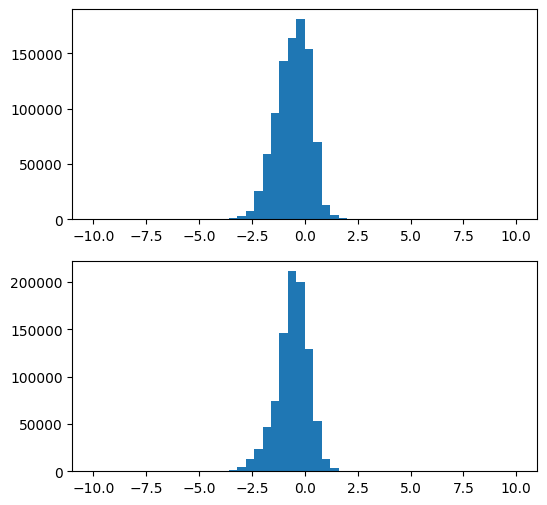

In [9]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(6,6))
_ = ax1.hist(v.flatten(), bins=50, range=(-10,10))
_ = ax2.hist(u.flatten(), bins=50, range=(-10,10))

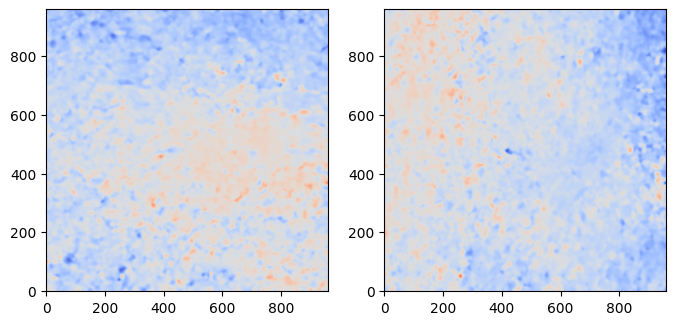

In [10]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4))

ax1.imshow(v,origin="lower",vmin=-5,vmax=5,cmap="coolwarm")
ax2.imshow(u,origin="lower",vmin=-5,vmax=5,cmap="coolwarm")

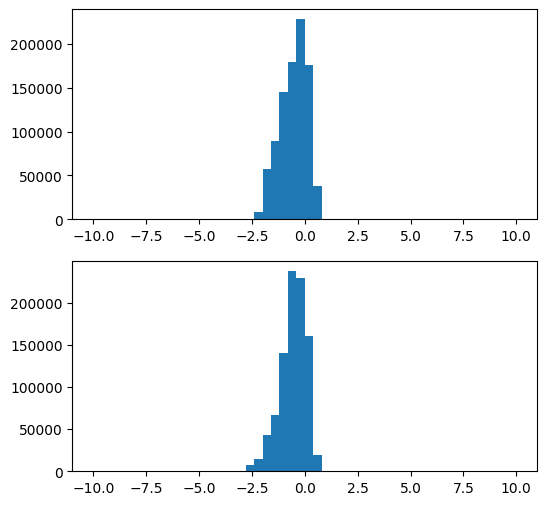

In [11]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(6,6))
_ = ax1.hist(v_filter.flatten(), bins=50, range=(-10,10))
_ = ax2.hist(u_filter.flatten(), bins=50, range=(-10,10))

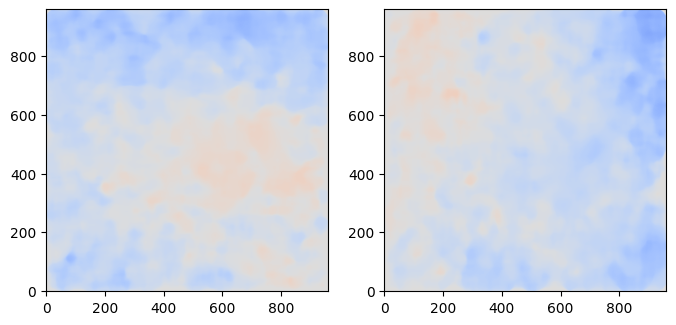

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4))

ax1.imshow(v_filter,origin="lower",vmin=-5,vmax=5,cmap="coolwarm")
ax2.imshow(u_filter,origin="lower",vmin=-5,vmax=5,cmap="coolwarm")

In [13]:
nr, nc = ref_img.shape
row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc), indexing='ij')
new_img_warp = warp(new_img, np.array([row_coords + v_filter, col_coords + u_filter]), mode='edge')
new_img_warp_no_filter = warp(new_img, np.array([row_coords + v, col_coords + u]), mode='edge')

In [14]:
ImageBlinker(ref_img, new_img)

In [15]:
ImageBlinker(ref_img, new_img_warp)

In [16]:
ImageBlinker(ref_img, new_img_warp_no_filter)

In [17]:
ref_img_8u = cv2.normalize(ref_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
new_img_8u = cv2.normalize(new_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

In [18]:
of = cv2.calcOpticalFlowFarneback(ref_img_8u, new_img_8u, None, *of_params)
of_x, of_y = of[...,0], of[...,1]
of_x_filter = medfilt2d(of_x, kernel_size=of_rebin_size)
of_y_filter = medfilt2d(of_y, kernel_size=of_rebin_size)

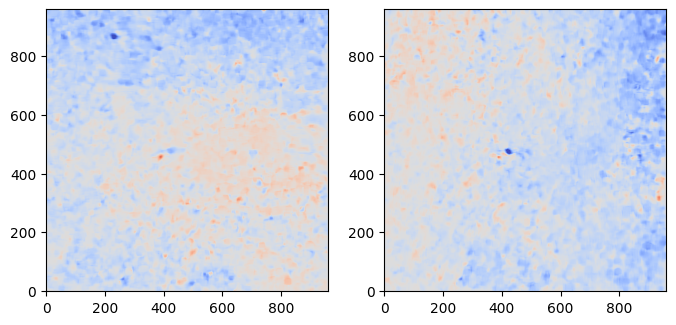

In [19]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4))

ax1.imshow(of_y,origin="lower",vmin=-5,vmax=5,cmap="coolwarm")
ax2.imshow(of_x,origin="lower",vmin=-5,vmax=5,cmap="coolwarm")

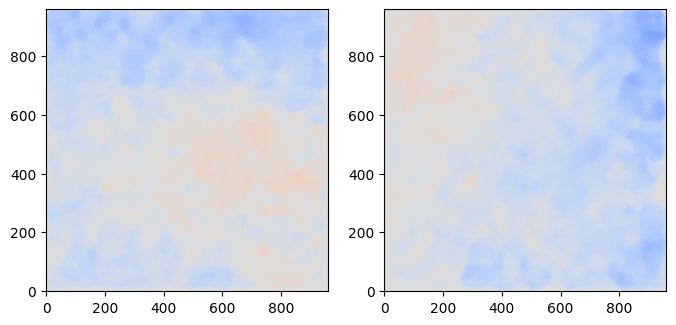

In [20]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4))

ax1.imshow(of_y_filter,origin="lower",vmin=-5,vmax=5,cmap="coolwarm")
ax2.imshow(of_x_filter,origin="lower",vmin=-5,vmax=5,cmap="coolwarm")

In [21]:
new_img_warp_cv2 = warp(new_img, np.array([row_coords + of_y_filter, col_coords + of_x_filter]), mode='edge')

In [22]:
new_img_wrap_cv2_no_filter = warp(new_img, np.array([row_coords + of_y, col_coords + of_x]), mode='edge')

In [23]:
ImageBlinker(ref_img, new_img_warp_cv2)

In [24]:
ImageBlinker(ref_img, new_img_wrap_cv2_no_filter)

In [25]:
destretch_kernel_size = 128
destretch_step_size = destretch_kernel_size//2
patch_ny, patch_nx = (np.array(ref_img.shape)/destretch_step_size).astype(int)
patch_ny = patch_ny - 1
patch_nx = patch_nx - 1

In [26]:
shift_grid = np.zeros((patch_ny, patch_nx, 2))

In [27]:
for ii in range(patch_nx):
    for jj in range(patch_ny):
        image = ref_img[jj*destretch_step_size:jj*destretch_step_size + destretch_kernel_size,
                        ii*destretch_step_size:ii*destretch_step_size + destretch_kernel_size,]
        offset_image = new_img[jj*destretch_step_size:jj*destretch_step_size + destretch_kernel_size,
                        ii*destretch_step_size:ii*destretch_step_size + destretch_kernel_size,]

        if ii == 0:
            image = image[:,int(0.25*destretch_kernel_size):]
            offset_image = offset_image[:,int(0.25*destretch_kernel_size):]
        elif ii == patch_nx - 1:
            image = image[:,:int(0.75*destretch_kernel_size)]
            offset_image = offset_image[:,:int(0.75*destretch_kernel_size)]
        
        if jj == 0:
            image = image[int(0.25*destretch_kernel_size):,:]
            offset_image = offset_image[int(0.25*destretch_kernel_size):,:]
        elif jj == patch_ny - 1:
            image = image[:int(0.75*destretch_kernel_size),:]
            offset_image = offset_image[:int(0.75*destretch_kernel_size),:]
        
        shift, error, diffphase = phase_cross_correlation(
                image, offset_image, upsample_factor=10
        )
        shift_grid[jj, ii, :] = shift

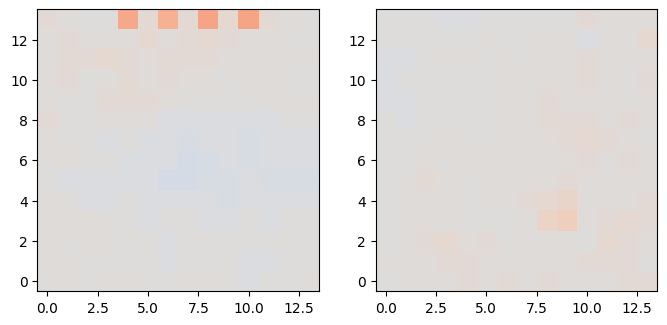

In [28]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4))
ax1.imshow(shift_grid[:,:,0], origin="lower",vmin=-5,vmax=5,cmap="coolwarm")
ax2.imshow(shift_grid[:,:,1], origin="lower",vmin=-5,vmax=5,cmap="coolwarm")

In [29]:
shift_threshold = 8*np.std(shift_grid[1:-1,1:-1,:])
bad_shift_indices = np.where(shift_grid > shift_threshold)

In [30]:
bad_shift_indices_boundary = ([], [], [])

for index_0, index_1, index_2 in zip(*np.where(shift_grid > shift_threshold)):
    if (index_0 == 0) or (index_0 == patch_ny - 1) or (index_1 == 0) or (index_1 == patch_nx - 1):
        bad_shift_indices_boundary[0].append(index_0)
        bad_shift_indices_boundary[1].append(index_1)
        bad_shift_indices_boundary[2].append(index_2)

In [31]:
shift_grid[bad_shift_indices_boundary] = np.nan
shift_grid[:,:,0] = interpolate_replace_nans(shift_grid[:,:,0], Gaussian2DKernel(2,2))
shift_grid[:,:,1] = interpolate_replace_nans(shift_grid[:,:,1], Gaussian2DKernel(2,2))

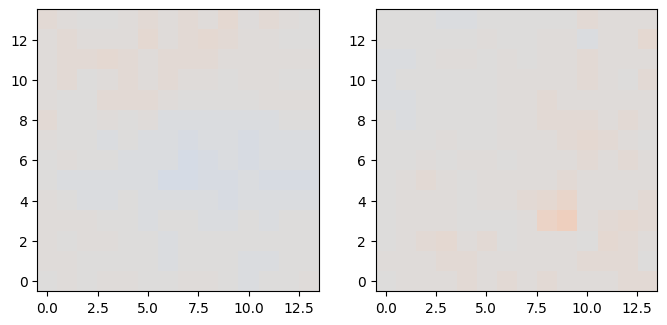

In [32]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4))
ax1.imshow(shift_grid[:,:,0], origin="lower",vmin=-5,vmax=5,cmap="coolwarm")
ax2.imshow(shift_grid[:,:,1], origin="lower",vmin=-5,vmax=5,cmap="coolwarm")

In [33]:
row_coords_patch, col_coords_patch = np.meshgrid(np.arange((destretch_kernel_size - 1)/2, nr - 1, destretch_step_size),
                                                np.arange((destretch_kernel_size - 1)/2, nc - 1, destretch_step_size), indexing='ij')

In [34]:
shift_grid_x_interp = interpn((col_coords_patch[0,:], row_coords_patch[:,0]), 
                                shift_grid[:,:,1], np.stack([row_coords, col_coords],axis=-1),
                                fill_value=None, bounds_error=False, method="linear")

shift_grid_y_interp = interpn((col_coords_patch[0,:], row_coords_patch[:,0]), 
                                shift_grid[:,:,0], np.stack([row_coords, col_coords],axis=-1),
                                fill_value=None, bounds_error=False, method="linear")

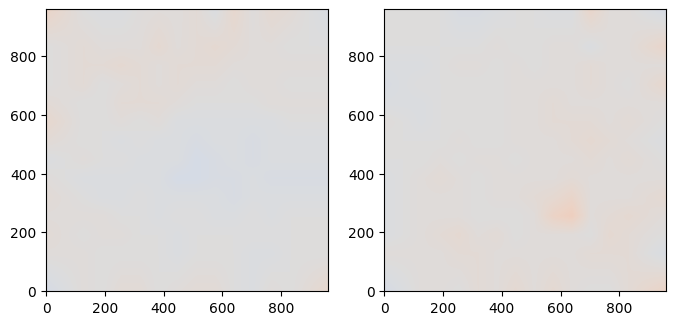

In [35]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4))

ax1.imshow(shift_grid_y_interp, vmin=-5, vmax=5, cmap="coolwarm", origin="lower")
ax2.imshow(shift_grid_x_interp, vmin=-5, vmax=5, cmap="coolwarm", origin="lower")

In [36]:
new_img_warp_destretch = warp(new_img, np.array([row_coords + shift_grid_y_interp, col_coords + shift_grid_x_interp]), mode='edge')

In [37]:
ImageBlinker(ref_img, new_img_warp_destretch)